In [39]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [40]:
housing_path = "C://Users//gabme//OneDrive//Documentos//projetospython//housingprices//Housing.csv"
housing_df = pd.read_csv(housing_path)

# Data Visualization
Taking a look at what we´re working with

In [41]:
housing_df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [42]:
housing_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


 No null lines, most of them are categorical

In [43]:
housing_df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


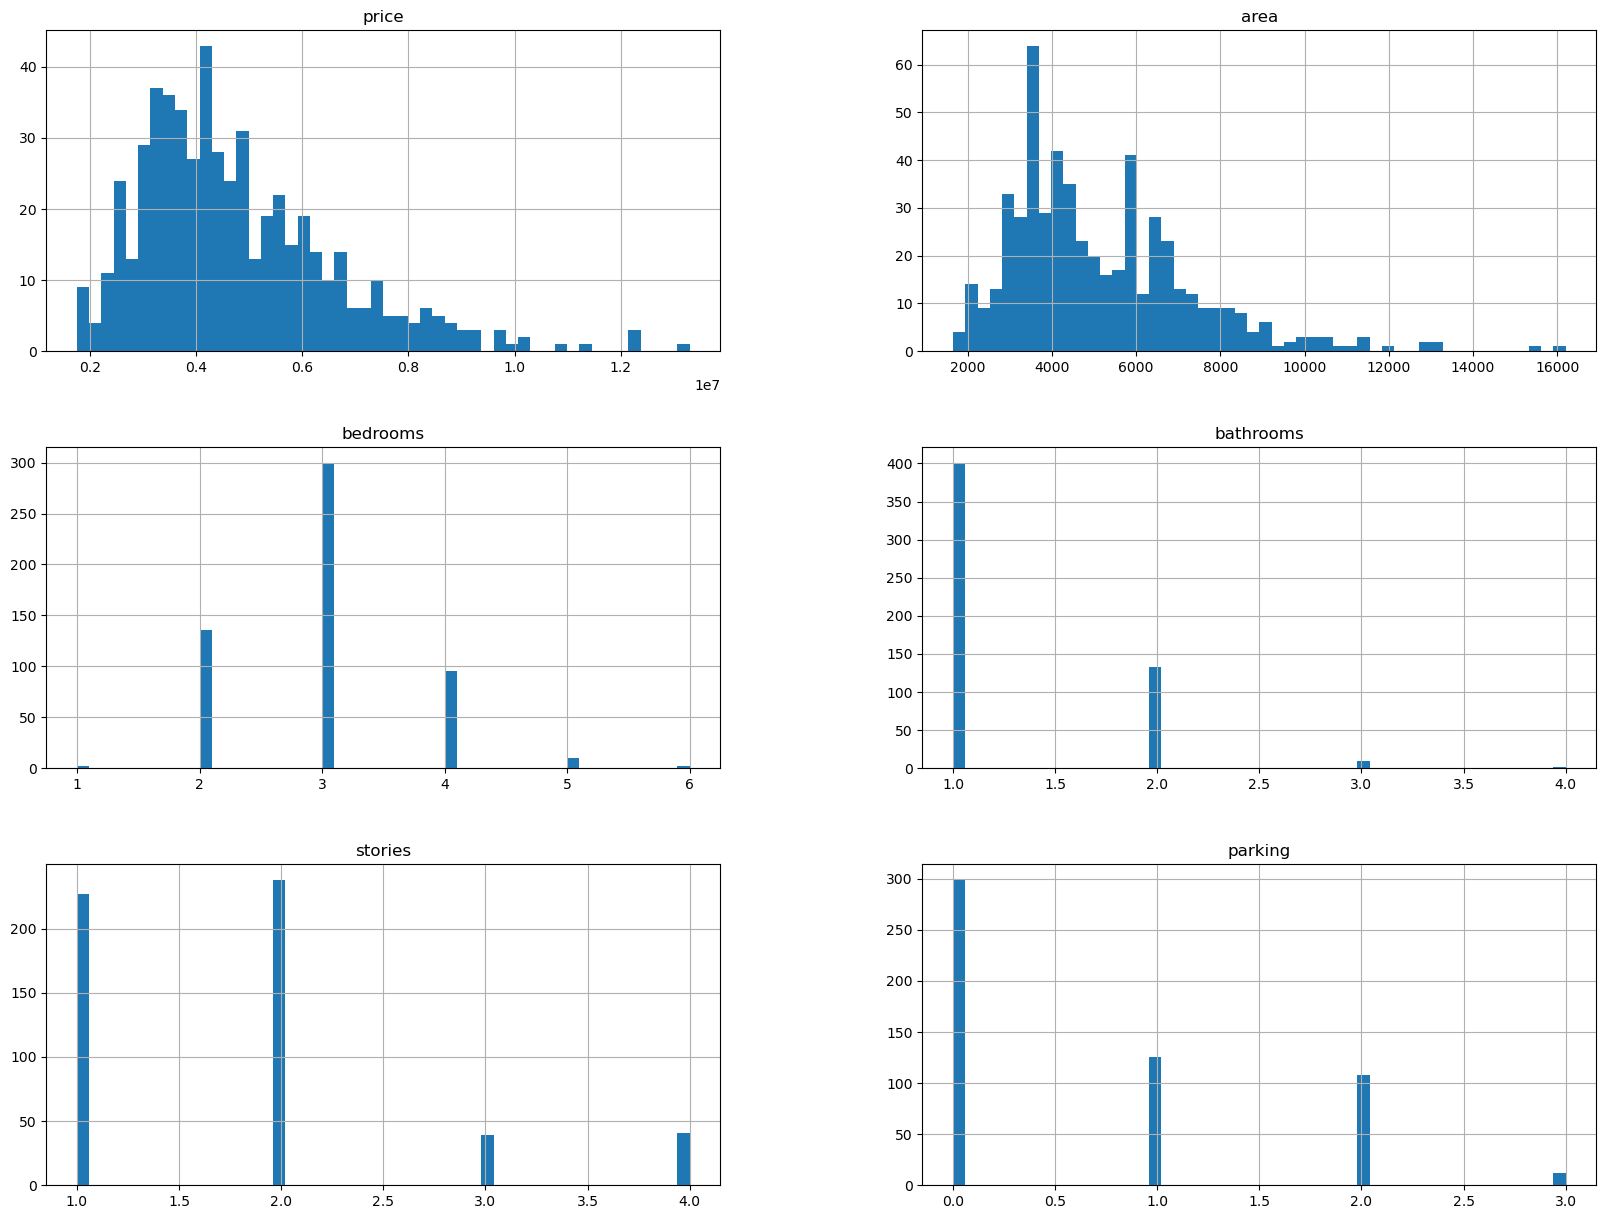

In [44]:
housing_df.hist(bins=50, figsize=(20,15))
plt.show() 

We can note some outliers on the area and price histograms

In [45]:
housing_df["mainroad"].value_counts()["no"]

77

In [46]:
cat_columns = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"]

for column in cat_columns:
    print(column,":", housing_df[column].nunique(), "types of answer")

mainroad : 2 types of answer
guestroom : 2 types of answer
basement : 2 types of answer
hotwaterheating : 2 types of answer
airconditioning : 2 types of answer
prefarea : 2 types of answer
furnishingstatus : 3 types of answer


In [47]:
print("Area mean:",housing_df["area"].mean())

Area mean: 5150.54128440367


# Creating the test and training sets
With a dataset this small, a good move is to use a stratified split, so, we´re going to use the StratifiedShuffleSplit from scikit
But first, we need to divide the dataset in groups based on the price. We will exclude outliers based on percentile techniques

In [48]:
q1 = np.percentile(housing_df["price"], 25)
q3 = np.percentile(housing_df["price"], 75)

iqr = q3-q1

min_value = q1 - 1.5*iqr
max_value = q3 + 1.5*iqr

In [49]:
housing_df = housing_df[(housing_df["price"] > min_value) & (housing_df["price"] < max_value)]
housing_df.reset_index(drop=True, inplace=True)

In [50]:
housing_df.shape

(530, 13)

In [51]:
housing_df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.300000e+02,530.000000,530.000000,530.000000,530.000000,530.000000
mean,4.600663e+06,5061.518868,2.943396,1.260377,1.788679,0.664151
std,1.596119e+06,2075.449479,0.730515,0.464359,0.861190,0.843320
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3547.500000,2.000000,1.000000,1.000000,0.000000
50%,4.270000e+06,4500.000000,3.000000,1.000000,2.000000,0.000000
75%,5.600000e+06,6315.750000,3.000000,1.000000,2.000000,1.000000
max,9.100000e+06,15600.000000,6.000000,3.000000,4.000000,3.000000


In [52]:
#Creating the categories for the stratified split, we´re creating categories of price
housing_df["price_cat"] = pd.cut(housing_df["price"],
                               bins=[0., 2000000.0, 4000000.0, 6000000.0, np.inf],
                               labels=[1,2,3,4])
                        

<Axes: >

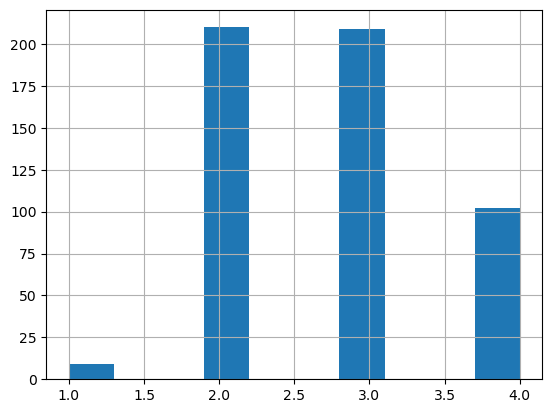

In [53]:
#Checking out the distribution of the price
housing_df["price_cat"].hist()

In [54]:
#Creating the splits:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["price_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [55]:
#Checking out the percentages on both sets
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

price_cat
2    0.396226
3    0.396226
4    0.188679
1    0.018868
Name: count, dtype: float64

In [56]:
strat_train_set["price_cat"].value_counts() / len(strat_train_set)

price_cat
2    0.396226
3    0.393868
4    0.193396
1    0.016509
Name: count, dtype: float64

# Searching for correlations
Now we´re going to do some more data visualization before cleaning out the data

In [57]:
#We´re disposing the price_cat attribute since it wont be needed anymore
for sample in (strat_train_set, strat_test_set):
    sample.drop("price_cat", axis = 1, inplace=True)

In [58]:
housing_train = strat_train_set.copy()

In [59]:
housing_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
141,5523000,6900,3,1,1,yes,yes,yes,no,no,0,yes,semi-furnished
221,4620000,2870,2,1,2,yes,yes,yes,no,no,0,yes,semi-furnished
386,3500000,9500,3,1,2,yes,no,no,no,no,3,yes,unfurnished
239,4480000,4510,4,1,2,yes,no,no,no,yes,2,no,semi-furnished
488,2660000,4000,3,1,1,yes,no,no,no,no,0,no,semi-furnished


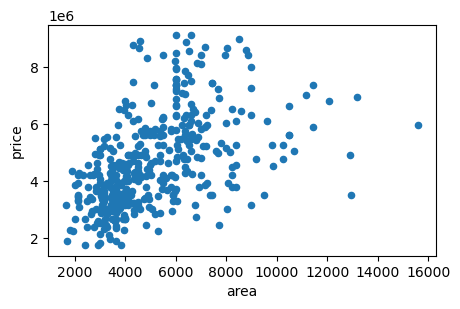

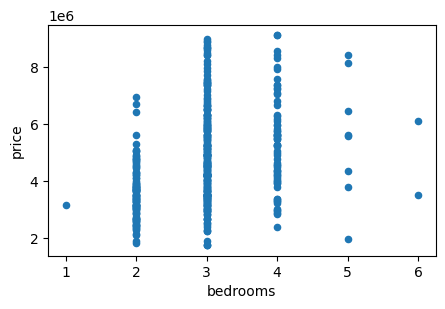

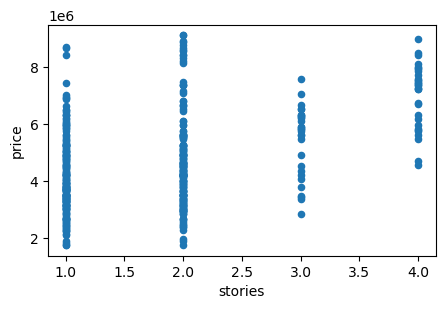

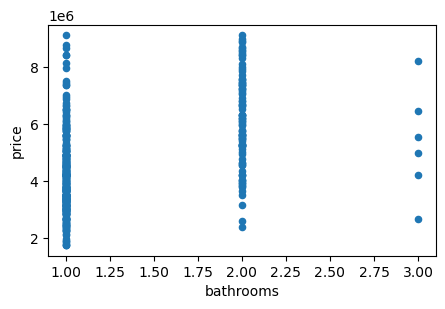

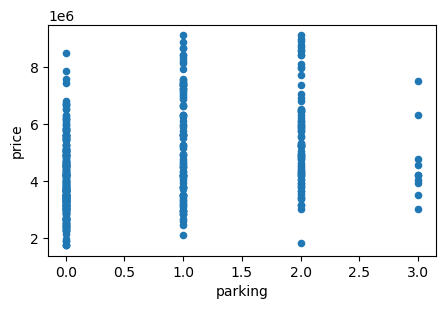

In [60]:
columns = ["area", "bedrooms", "stories", "bathrooms", "parking"]
for column in columns:
    housing_train.plot(kind="scatter", x=column, y="price", figsize=(5,3))
    plt.show()

There is a weak linear relation between the area and the price. Now, we´re trying to see if another variable comes in play

Ok, now let´s look at a correlation matrix

In [61]:
#Creating a dataframe with the numerical attributes of housing
housing_num = housing_train.select_dtypes(include=["int64"])
housing_num.head()

,price,area,bedrooms,bathrooms,stories,parking
141,5523000,6900,3,1,1,0
221,4620000,2870,2,1,2,0
386,3500000,9500,3,1,2,3
239,4480000,4510,4,1,2,2
488,2660000,4000,3,1,1,0


In [62]:
#Pearson Correlation Coeficient
corr_matrix = housing_num.corr()
corr_matrix["price"].sort_values(ascending=False)

price        1.000000
area         0.500911
bathrooms    0.464828
stories      0.428521
bedrooms     0.346193
parking      0.342433
Name: price, dtype: float64

Let´s look now at a scatter matrix

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='area', ylabel='price'>,
        <Axes: xlabel='bathrooms', ylabel='price'>,
        <Axes: xlabel='stories', ylabel='price'>,
        <Axes: xlabel='parking', ylabel='price'>,
        <Axes: xlabel='bedrooms', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='area'>,
        <Axes: xlabel='area', ylabel='area'>,
        <Axes: xlabel='bathrooms', ylabel='area'>,
        <Axes: xlabel='stories', ylabel='area'>,
        <Axes: xlabel='parking', ylabel='area'>,
        <Axes: xlabel='bedrooms', ylabel='area'>],
       [<Axes: xlabel='price', ylabel='bathrooms'>,
        <Axes: xlabel='area', ylabel='bathrooms'>,
        <Axes: xlabel='bathrooms', ylabel='bathrooms'>,
        <Axes: xlabel='stories', ylabel='bathrooms'>,
        <Axes: xlabel='parking', ylabel='bathrooms'>,
        <Axes: xlabel='bedrooms', ylabel='bathrooms'>],
       [<Axes: xlabel='price', ylabel='stories'>,
        <Axes: xlabel='area', ylabe

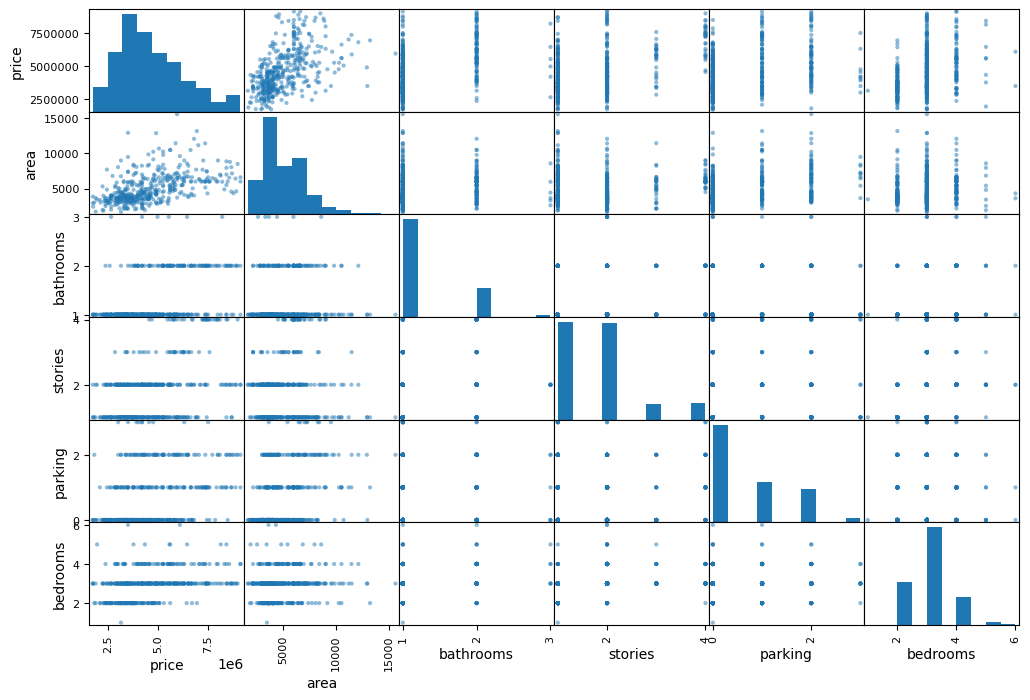

In [63]:
attributes=["price", "area", "bathrooms", "stories", "parking", "bedrooms"]

scatter_matrix(housing_num[attributes], figsize=(12,8))

# Data Preparation

In [107]:
ord_att = ["furnishingstatus"]
hot_att = ["mainroad", "hotwaterheating", "airconditioning", "prefarea", "basement", "guestroom"]
num_att = ["area"]
all_columns = set(housing_train.columns)
unchanged_att = list(all_columns - set(hot_att) - set(num_att) - set(ord_att))


pipeline = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="if_binary"), hot_att),
    ("num_treatment", StandardScaler() , num_att),
    ("ordinal", OrdinalEncoder(), ord_att),
    ("passthrough", "passthrough", unchanged_att)
    ])

housing_transformed = pipeline.fit_transform(housing_train)

transformed_names = pipeline.get_feature_names_out()

housing_transformed_df = pd.DataFrame(housing_transformed, columns = transformed_names)

# Machine Learning
We are going to do the linear regression manually, why not?

In [108]:
y = housing_transformed_df["passthrough__price"].values
housing_transformed_df = housing_transformed_df.drop("passthrough__price", axis=1)
features = housing_transformed_df.columns
X_b = housing_transformed_df[features].values

X_b = np.c_[np.ones(X_b.shape[0]), X_b]

print(X_b.shape)

(424, 13)


In [109]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [110]:
y_predictions = X_b.dot(theta_best)

mse = mean_squared_error(y, y_predictions)
rmse = np.sqrt(mse)
rmse

945117.4013703526

Let´s check out the gradient descent for this linear regression

In [112]:
chi = 0.001
num_iterations = 100000
size = 424
threshold = 0.001

theta_gradient = np.random.randn(13, 1)

for i in range(num_iterations):
    parameters = 2/size * X_b.T.dot(X_b.dot(theta_gradient) - y)
    aux = theta_gradient.copy()
    theta_gradient = theta_gradient - chi*parameters
    if np.linalg.norm(theta_gradient-aux) < threshold:
        break

In [114]:
y = y.reshape(-1, 1)
y_predictions_gradient = X_b.dot(theta_gradient)
mse_gradient = mean_squared_error(y, y_predictions_gradient)
rmse_gradient = np.sqrt(mse_gradient)
rmse_gradient

945117.8507844548

# Testing with the test samples

In [121]:
test_samples = strat_test_set.copy()
test_prepared = pipeline.transform(test_samples)
test_names = pipeline.get_feature_names_out()
test_df = pd.DataFrame(test_prepared, columns = test_names)

labels = test_df["passthrough__price"].values
test_df = test_df.drop("passthrough__price", axis=1)
feat = test_df.columns

test_b = test_df[feat].values

test_b = np.c_[np.ones(test_b.shape[0]), test_b]

In [122]:
labels = labels.reshape(-1, 1)
test_predictions = test_b.dot(theta_gradient)
fin_mse = mean_squared_error(labels, test_predictions)
fin_rmse = np.sqrt(fin_mse)
fin_rmse

853356.9142623527

In [123]:
area_values = strat_train_set["area"]

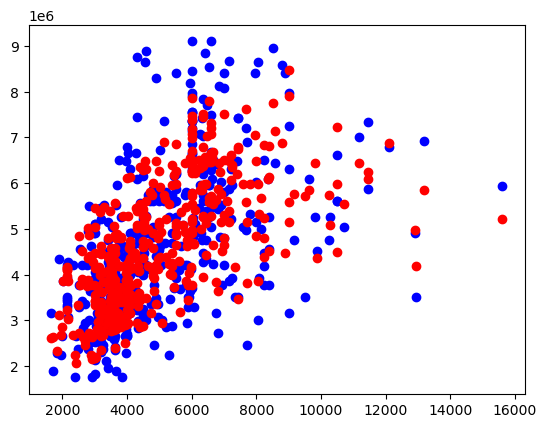

In [124]:
plt.scatter(area_values, y, color='blue')
plt.scatter(area_values, y_predictions_poly, color='red')
plt.show()